In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import sys

import random

import numpy as np

from PIL import Image

import torch
from torchvision.transforms.functional import to_pil_image

In [2]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

In [3]:
from worker.prompt_generation.prompt_generator import initialize_prompt_list_from_csv
from worker.prompt_generation.prompt_generator import generate_prompts_proportional_selection, generate_base_prompts, load_base_prompts
from worker.image_generation.scripts.stable_diffusion_base_script import StableDiffusionBaseScript

INFO: Created a temporary directory at /tmp/tmpnefm5djx
INFO: Writing /tmp/tmpnefm5djx/_remote_module_non_scriptable.py


In [4]:
from stable_diffusion import StableDiffusion, CLIPTextEmbedder

In [5]:
csv_dataset_path = '../kcg-ml-image-pipeline/input/civitai_phrases_database_v6.csv'
csv_base_prompts = '../kcg-ml-image-pipeline/input/dataset-config/environmental/base-prompts-environmental.csv'
model_path = '../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors'
tokenizer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_tokenizer'
transformer_path = '../kcg-ml-image-pipeline/input/model/clip/txt_emb_model'

In [6]:
phrases, phrases_token_size, positive_count_list, negative_count_list = initialize_prompt_list_from_csv(csv_dataset_path, 0)

In [7]:
base_prompt_population = load_base_prompts(csv_base_prompts)

In [8]:
len(base_prompt_population)

62

In [9]:
txt2img = StableDiffusionBaseScript(
    sampler_name="ddim",
    # sampler_name="ddpm",
    n_steps=50,
    force_cpu=False,
    cuda_device='cuda',
)

In [10]:
txt2img.initialize_latent_diffusion(
    autoencoder=None, 
    clip_text_embedder=None, 
    unet_model=None,
    path=model_path, 
    force_submodels_init=True)

  encoder initialization...[DONE]	941.74ms                                        
  decoder initialization...[DONE]	366.96ms                                        
Autoencoder initialization...[DONE]	1,312.61ms                                    
U-Net initialization...[DONE]	6,474.26ms                                          
Latent Diffusion model initialization...[DONE]	7.58ms                             
stable diffusion checkpoint loading, from ../kcg-ml-image-pipeline/input/model/sd/v1-5-pruned-emaonly/v1-5-pruned-emaonly.safetensors...[DONE]	196.37ms
	missing keys 2: ['beta', 'alpha_bar']
	extra keys 14: ['alphas_cumprod', 'alphas_cumprod_prev', 'betas', 'log_one_minus_alphas_cumprod', 'model_ema.decay', 'model_ema.num_updates', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'posterior_variance', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod']
model state loading...[DONE]	1,

In [11]:
clip_text_embedder = CLIPTextEmbedder(device='cuda')

In [12]:
clip_text_embedder.load_submodels(
    tokenizer_path=tokenizer_path,
    transformer_path=transformer_path
);

Loading tokenizer and transformer...[DONE]	1,152.89ms                             


In [13]:
def get_image_data(images: torch.Tensor):
    # Map images to `[0, 1]` space and clip
    images = torch.clamp((images + 1.0) / 2.0, min=0.0, max=1.0)
    # Transpose to `[batch_size, height, width, channels]` and convert to numpy
    images = images.cpu()
    images = images.permute(0, 2, 3, 1)
    images = images.detach().float().numpy()

    return Image.fromarray((255. * images[0]).astype(np.uint8))

In [11]:
positive_prompt = '2D environmental side scrolling,  at the city, in the style of h Hirohi- kiyohara and Akiyiyuyuki, pixel gloss style;'
negative_prompt = ''

seed = random.randint(0, 2 ** 24 - 1)
cfg_strength = 12
image_width = 512
image_height = 512

In [12]:
embedded_prompts = clip_text_embedder(positive_prompt)
negative_embedded_prompts = clip_text_embedder(negative_prompt)

In [13]:
latent = txt2img.generate_images_latent_from_embeddings(
    batch_size=1,
    embedded_prompt=embedded_prompts,
    null_prompt=negative_embedded_prompts,
    uncond_scale=cfg_strength,
    seed=seed,
    w=image_width,
    h=image_height
)

Sample...[DONE]	104,652.12ms                                                      


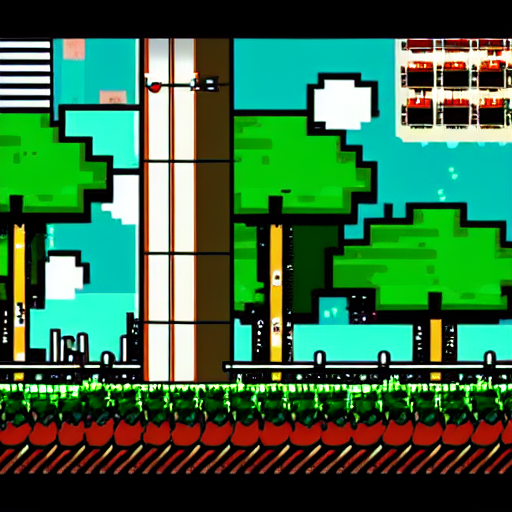

In [14]:
images = txt2img.get_image_from_latent(latent)
get_image_data(images)

In [14]:
from minio import Minio
import requests
import msgpack

In [15]:
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

In [16]:
bucket_name = 'datasets'
object_name = 'environmental/0001/000000_data.msgpack'
local_file_path = '../kcg-ml-image-pipeline/output/dataset/' + object_name
# local_file_path='./data.msgpack'

In [16]:
def connect_to_minio(minio_addr, access_key, secret_key):
    # Initialize the MinIO client
    client = Minio(minio_addr, access_key, secret_key, secure=False)

    #Check server status
    try:
        response = requests.get("http://" + minio_addr + "/minio/health/live", timeout=5)
        if response.status_code == 200:
            print("Connected to MinIO server.")
        else:
            return None
    except requests.RequestException as e:
        return None
    
    return client

In [16]:
client = connect_to_minio(MINIO_ADDRESS, access_key, secret_key)

Connected to MinIO server.


In [18]:
client.fget_object(bucket_name, object_name, local_file_path)

In [17]:
with open(local_file_path, 'rb') as f:
    data = f.read()
decoded_data = msgpack.unpackb(data)

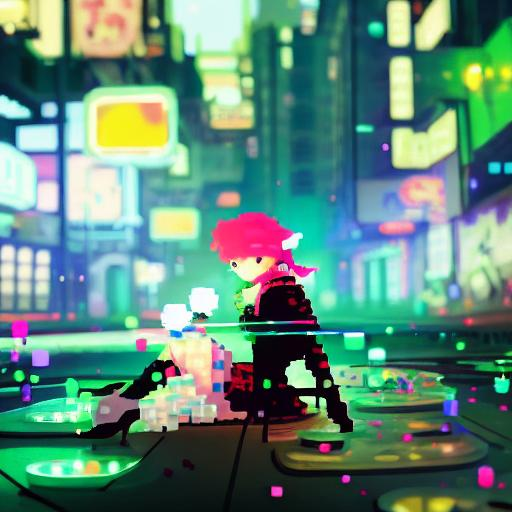

In [18]:
Image.open('../kcg-ml-image-pipeline/output/dataset/image/environmental/0001/000000.jpg')

In [19]:
positive_prompt = decoded_data['positive_prompt']
negative_prompt = decoded_data['negative_prompt']
seed = decoded_data['seed']
cfg_strength = decoded_data['cfg_strength']
image_width = decoded_data['image_width']
image_height = decoded_data['image_height']

In [20]:
embedded_prompts = clip_text_embedder(positive_prompt)
negative_embedded_prompts = clip_text_embedder(negative_prompt)

In [21]:
latent = txt2img.generate_images_latent_from_embeddings(
    batch_size=1,
    embedded_prompt=embedded_prompts,
    null_prompt=negative_embedded_prompts,
    uncond_scale=cfg_strength,
    seed=seed,
    w=image_width,
    h=image_height
)

Sample...[DONE]	5,632.64ms                                                        


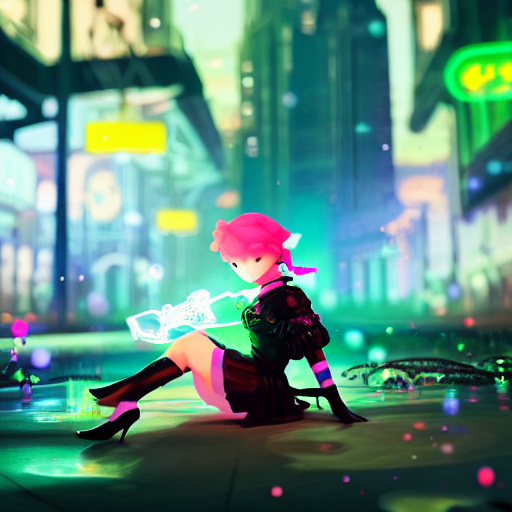

In [22]:
images = txt2img.get_image_from_latent(latent)
get_image_data(images)

In [1]:
import torch

In [33]:
from scipy.stats import norm

In [44]:
import numpy as np

from matplotlib import pyplot

In [42]:
x = np.arange(1000) / 100 - 5

In [45]:
y = list(map(norm.cdf, x))

In [46]:
exp2x = np.exp(2 * x)
z = 0.5 * (1 + (exp2x - 1) / (exp2x + 1))

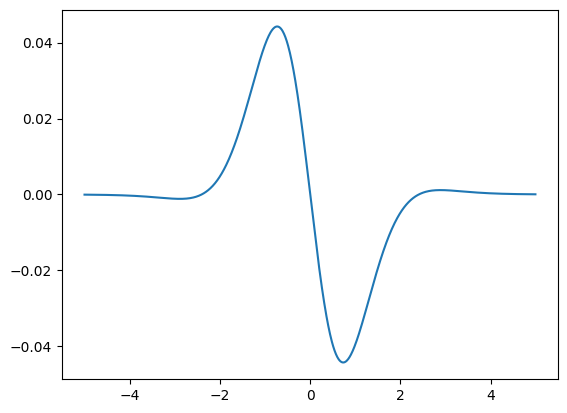

In [48]:
pyplot.plot(x, y - z)

In [75]:
from tqdm.auto import tqdm

In [66]:
func_mu = lambda x: 3 * x
func_sigma = lambda x: torch.log(torch.abs(x) + 1)

In [138]:
def log_likehood(mean, sigma, targets, eps=1e-5):
    
    sigma2 = sigma ** 2
    
    loss = (((targets - mean) ** 2) / (sigma2 + eps) + torch.log(sigma2)) / 2
    
    return loss.mean()

In [80]:
x = torch.rand(10000) * 10 - 5
x = x.cuda()

mu = func_mu(x)
sigma = func_sigma(x)

y = torch.normal(mu, sigma)

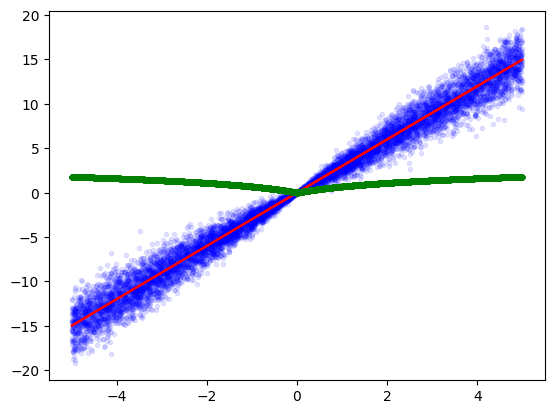

In [81]:
pyplot.plot(x.cpu().numpy(), y.cpu().numpy(), '.', color='blue', alpha=0.1)
pyplot.plot(x.cpu().numpy(), mu.cpu().numpy(), color='red')
pyplot.plot(x.cpu().numpy(), sigma.cpu().numpy(), '.', color='green')

In [114]:
def _init_weights(model):

    for m in model.modules():
        if isinstance(m, torch.nn.Conv2d):
            torch.nn.init.kaiming_normal_(
                m.weight, mode='fan_in', nonlinearity='linear')
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.zeros_(m.bias)

In [139]:
# model = torch.nn.Linear(1, 1).cuda()
model = torch.nn.Sequential(
    torch.nn.Linear(1, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 2),
).cuda()

_init_weights(model)

In [140]:
LR = 1e-3
BATCH_SIZE = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)

In [141]:
mses = list()

for epoch in tqdm(range(2000)):
    
    model.train()
    
    for i in range(0, x.shape[0], BATCH_SIZE):
    
        optimizer.zero_grad()

        mu_sigma = model(x[i:i+BATCH_SIZE].unsqueeze(-1))

        # backward

        # mse = torch.nn.functional.mse_loss(pred, y[i:i+BATCH_SIZE].unsqueeze(-1))
        
        mse = log_likehood(mu_sigma[..., :1], mu_sigma[..., 1:], y[i:i+BATCH_SIZE].unsqueeze(-1))

        loss = mse

        loss.backward()
        optimizer.step()
    
        mses.append(mse.detach().cpu().numpy())

  0%|          | 0/2000 [00:00<?, ?it/s]

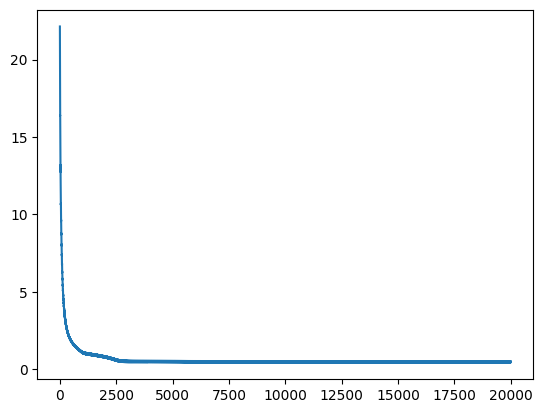

In [142]:
pyplot.plot(mses)

In [148]:
mu_sigma = model(x.unsqueeze(-1)).detach().cpu().numpy()

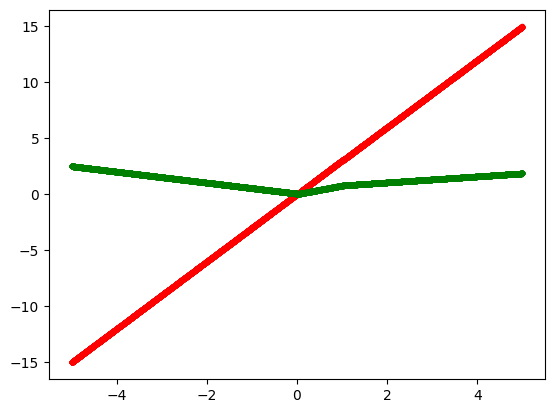

In [151]:
pyplot.plot(x.cpu().numpy(), mu_sigma[..., 0], '.', color='red')
pyplot.plot(x.cpu().numpy(), np.abs(mu_sigma[..., 1]), '.', color='green')